In [1]:
import pairtools
import os
import pairlib.scalings
import pairlib
import bioframe
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sbn
from NGS import HiCTools as HT
from collections import defaultdict

# Define plotting parameters

In [2]:
matplotlib.rcParams.update({"pdf.fonttype": 42})

# Define functions

In [3]:
def recDict():
    return defaultdict(recDict)

# Set WD

In [4]:
os.chdir("/groups/gerlich/experiments/Experiments_004800/004869/")

# Define samples
WT and prometaphase are processed together to be able to downsample the pairs for both conditions

In [7]:
pairDir = ("/groups/gerlich/experiments/Experiments_004700/004755/"
           "Sequencing_data/exp4661/pairs/")

# Prometaphase rep1 is from experiments 4638 and rep2 is from exp4615
pathMap = {"G2": pairDir,
           "Meta_Rep1": "/groups/gerlich/experiments/Experiments_004700/004755/Sequencing_data/exp4727/pairs/",
           "Meta_Rep2": "/groups/gerlich/experiments/Experiments_004700/004755/Sequencing_data/exp4727/pairs/"}
barcodeMap = {"G2": "G2",
              "Meta_Rep1": "CAGATC_S8",
              "Meta_Rep2": "GTTTCG"}

# Load samples

In [8]:
pairs = {sample: {interType: HT.loadPairs(os.path.join(pathMap[sample], f"{barcodeMap[sample]}.{interType}.pairs.gz"))
                  for interType in ["cis", "trans"]}
         for sample in ["G2", "Meta_Rep1", "Meta_Rep2"]
         }

# Merge Metaphase replicates

In [9]:
pairsMerged = {}
pairsMerged["Meta"] = {}
pairsMerged["Meta"]["cis"] = pd.concat((pairs["Meta_Rep1"]["cis"], pairs["Meta_Rep2"]["cis"]))
pairsMerged["Meta"]["trans"] = pd.concat((pairs["Meta_Rep1"]["trans"], pairs["Meta_Rep2"]["trans"]))
pairsMerged["G2"] = {}
pairsMerged["G2"]["cis"] = pairs["G2"]["cis"]
pairsMerged["G2"]["trans"] = pairs["G2"]["trans"]

# Downsample pairs

In [10]:
pairsNew = HT.downSamplePairs(pairsMerged, Distance=1000)

# Get chromosome features

In [13]:
hg19_chromsizes = bioframe.fetch_chromsizes('hg19')
arms = HT.getArmsHg19()

# Calculate scaling plots

In [14]:
scs = {sample: {rType: pairlib.scalings.compute_scaling(
    pairsNew[sample][rType],
    arms,
    hg19_chromsizes
) for rType in ["cis", "trans"]}
    for sample in pairsNew.keys()
}

# Plot results

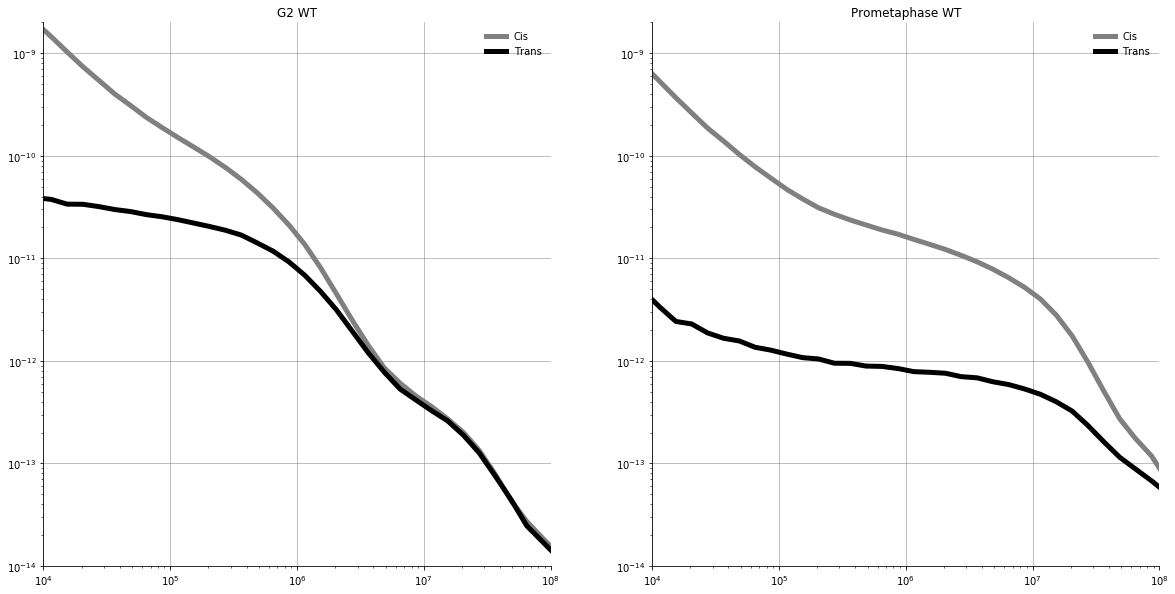

In [16]:
import warnings
warnings.simplefilter("ignore", RuntimeWarning)

colorMap = {"cis": "grey",
            "trans": "black"}

f, ax = plt.subplots(1, 2)
for index, sample in enumerate(["G2", "Meta"]):
    for rType in ["cis", "trans"]:
        sc = scs[sample][rType]
        sc_agg = (sc[0]
                  .groupby(['min_dist', 'max_dist'])
                  .agg({'n_pairs': 'sum', 'n_bp2': 'sum'})
                  .reset_index())
        ax[index].loglog(
            np.sqrt(sc_agg.min_dist * sc_agg.max_dist),
            sc_agg.n_pairs / sc_agg.n_bp2,
            label=f'{rType.capitalize()}', color=colorMap[rType], lw=5
        )
for i in range(0, 2):
    ax[i].grid(lw=0.5, color='gray')
    ax[i].set_xlim(10000, 100000000)
    ax[i].set_ylim(10**(-14), 2 * 10**(-9))
    ax[i].legend(frameon=False)
ax[0].set_title("G2 WT")
ax[1].set_title("Prometaphase WT")
f.set_size_inches(20, 10)
sbn.despine()
plt.show()